<a href="https://colab.research.google.com/github/nicholaspad/ECE473-Final-Project/blob/main/eigenlayer_slashing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Effect of Slashing on the Growth of EigenLayer Simulation
In this notebook we run inflow-outflow simulations to model the effect of slashing on the growth of EigenLayer over multiple time periods. We use various assumptions from Finality Capital Partners' value accrual model as well as our six additional parameters.

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 500

In [ ]:
#@title constants for the simulation
initial_validators = 2259375
portion_validators_restaking = 0.33
num_validators_opted_in = int(initial_validators * portion_validators_restaking)
num_validators_not_opted_in = initial_validators - num_validators_opted_in
base_slashing_penalty = 1 / 32
base_slashing_prob = 0.000133
eigenlayer_slashing_multiple = 50 # multiple for Additional Probability of Slashing

In [ ]:
#@title validator inflow-outflow in one time period
def random_lognormal(mean, std):
  var = std**2
  u = np.log((mean**2) / np.sqrt(mean**2 + var))
  sigma = np.sqrt(np.log(1 + var / (mean**2)))
  res = np.random.lognormal(u, sigma)
  while res > 1:
    res = np.random.lognormal(u, sigma)
  return res

def run_simulation(total_validators, num_validators_opted_in):
    num_validators_not_opted_in = total_validators - num_validators_opted_in

    additional_slashing_prob = random_lognormal(eigenlayer_slashing_multiple * base_slashing_prob,
                                                base_slashing_prob)

    total_slashing_prob = base_slashing_prob + additional_slashing_prob

    additional_slashing_penalty = random_lognormal(0.5, 0.1) # change mu for different additional_slashing_penalty
    total_slashing_penalty = base_slashing_penalty + additional_slashing_penalty

    additional_validator_exit_prob = (total_slashing_prob * additional_slashing_penalty) ** 0.35

    num_eth_validators_after_slashing_before_exit = num_validators_not_opted_in * (1 - base_slashing_prob) + num_validators_opted_in * (1 - total_slashing_prob)
    num_validators_opted_in_after_slashing_before_exit = num_validators_opted_in * (1 - total_slashing_prob)

    num_validators_opted_in_who_exit = num_validators_opted_in_after_slashing_before_exit * additional_validator_exit_prob

    num_eth_validators_after_slashing_and_exit = num_eth_validators_after_slashing_before_exit
    num_validators_opted_in_after_slashing_and_exit = num_validators_opted_in_after_slashing_before_exit - num_validators_opted_in_who_exit

    restaking_validator_inflow = abs(np.random.normal(0.07, 0.01))
    num_new_validators_opted_in = restaking_validator_inflow * num_validators_opted_in_after_slashing_and_exit
    num_validators_opted_in_after_slashing_and_exit += num_new_validators_opted_in

    return int(num_eth_validators_after_slashing_and_exit), int(num_validators_opted_in_after_slashing_and_exit)

#Optimism Levels for slashing

Average Total Slashing Penalty
* low: additional_slashing = 0.1
* medium: additional_slashing = 0.5
* high: additional_slashing = 0.9

Additional Probability of Slashing
* low: multiple = 3
* medium: multiple = 10
* high: multiple = 50

# Simulation

In [ ]:
df = pd.DataFrame(columns=['trial', 'year', 'scenario','total_validators', 'restaking_validators', 'percent'])

In [ ]:
TRIALS = 100
TIME_PERIODS = 20 # 5 year time periods
SCENARIO = 'high'
# num_validators = np.zeros((TRIALS, TIME_PERIODS, 3))
for t in range(TRIALS):
  trial =[]
  total_validators = initial_validators
  restaking_validators = num_validators_opted_in
  df.loc[len(df.index)] = [t,0, SCENARIO, total_validators, restaking_validators, (restaking_validators / total_validators) * 100] 
  for i in range(TIME_PERIODS):
      (total_validators, restaking_validators) = run_simulation(total_validators, restaking_validators)
      # print("total validators = {0} --> restaking validators = {1} ({2:.2f}%)".format(total_validators, restaking_validators, (restaking_validators / total_validators) * 100))
      # trial.append(np.array([total_validators, restaking_validators, (restaking_validators / total_validators) * 100]))
      df.loc[len(df.index)] = [t,i+1, SCENARIO, total_validators, restaking_validators, (restaking_validators / total_validators) * 100] 
  # print()
  # num_validators[t,:,:] = (np.array(trial))

In [ ]:
df

,trial,year,scenario,total_validators,restaking_validators,percent
0,0,0,low,2259375,745593,32.999967
1,0,1,low,2258122,732176,32.424112
2,0,2,low,2256792,722985,32.035961
3,0,3,low,2255420,713147,31.619255
4,0,4,low,2253981,704427,31.252570
...,...,...,...,...,...,...
6295,99,16,high,2040374,70,0.003431
6296,99,17,high,2040093,42,0.002059
6297,99,18,high,2039816,24,0.001177
6298,99,19,high,2039541,13,0.000637


In [ ]:
# sanity check
low = []
base = []
high = []
for year in range(11):
  df_filtered = df.loc[df['scenario'] == 'low']
  avg = df_filtered[df_filtered["year"] == year]["total_validators"].mean()
  low.append(avg)

  df_filtered = df.loc[df['scenario'] == 'base']
  avg = df_filtered[df_filtered["year"] == year]["total_validators"].mean()
  base.append(avg)

  df_filtered = df.loc[df['scenario'] == 'high']
  avg = df_filtered[df_filtered["year"] == year]["total_validators"].mean()
  high.append(avg)

print(low)
print(base)
print(high)

[2259375.0, 2258792.53, 2258193.76, 2257593.41, 2256948.51, 2256308.86, 2255634.02, 2254960.24, 2254268.58, 2253589.37, 2252888.99]
[2259375.0, 2258769.46, 2258170.27, 2257554.32, 2256940.09, 2256342.27, 2255736.41, 2255138.25, 2254510.05, 2253905.56, 2253265.22]
[2259375.0, 2258779.41, 2258168.84, 2257566.01, 2256971.43, 2256379.56, 2255784.17, 2255179.16, 2254587.1, 2254018.09, 2253427.14]


# Plots for the change in validators over time

In [ ]:
scenarios = {'high': 'High (50x base probability)', 'medium': 'Medium (10x base probability)', 'low': 'Low (3x base probability)'}
hue_order0 = ['High (50x base probability)', 'Medium (10x base probability)', 'Low (3x base probability)']

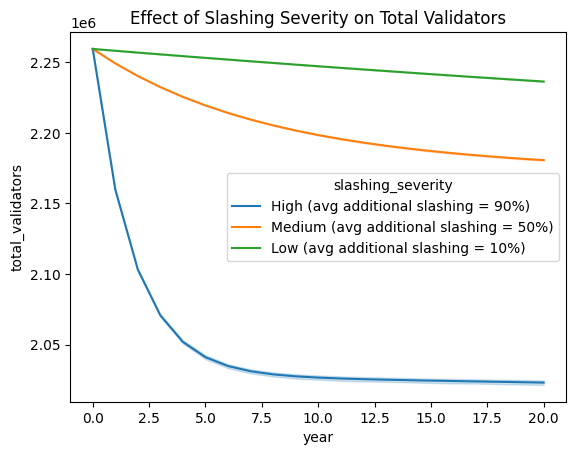

In [ ]:
g = sns.lineplot(data=df.assign(slashing_severity=df['scenario'].map(scenarios)), x="year", y="total_validators", hue='slashing_severity', hue_order= hue_order0).set(title='Effect of Slashing Severity on Total Validators')
# plt.legend(title='Scenario', loc='upper right', labels=['High (avg additional slashing = 80%)', 'Base (avg additional slashing = 50%)', 'Low (avg additional slashing = 20%)'])

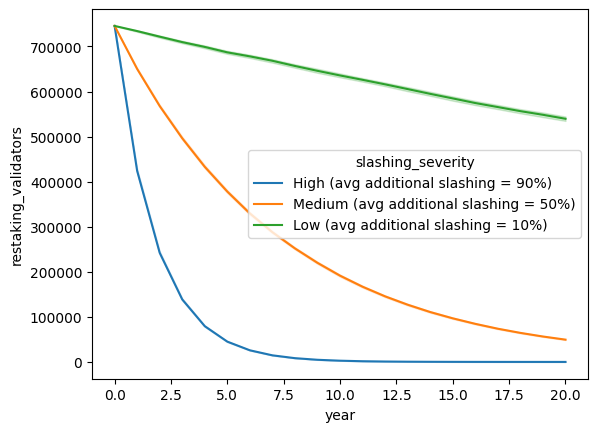

In [ ]:
g = sns.lineplot(data=df.assign(slashing_severity=df['scenario'].map(scenarios)), x="year", y="restaking_validators", hue='slashing_severity', hue_order=hue_order0)
# plt.legend(title='Scenario', loc='upper left', labels=['High (avg additional slashing = 80%)', 'Base (avg additional slashing = 50%)', 'Low (avg additional slashing = 20%)'])

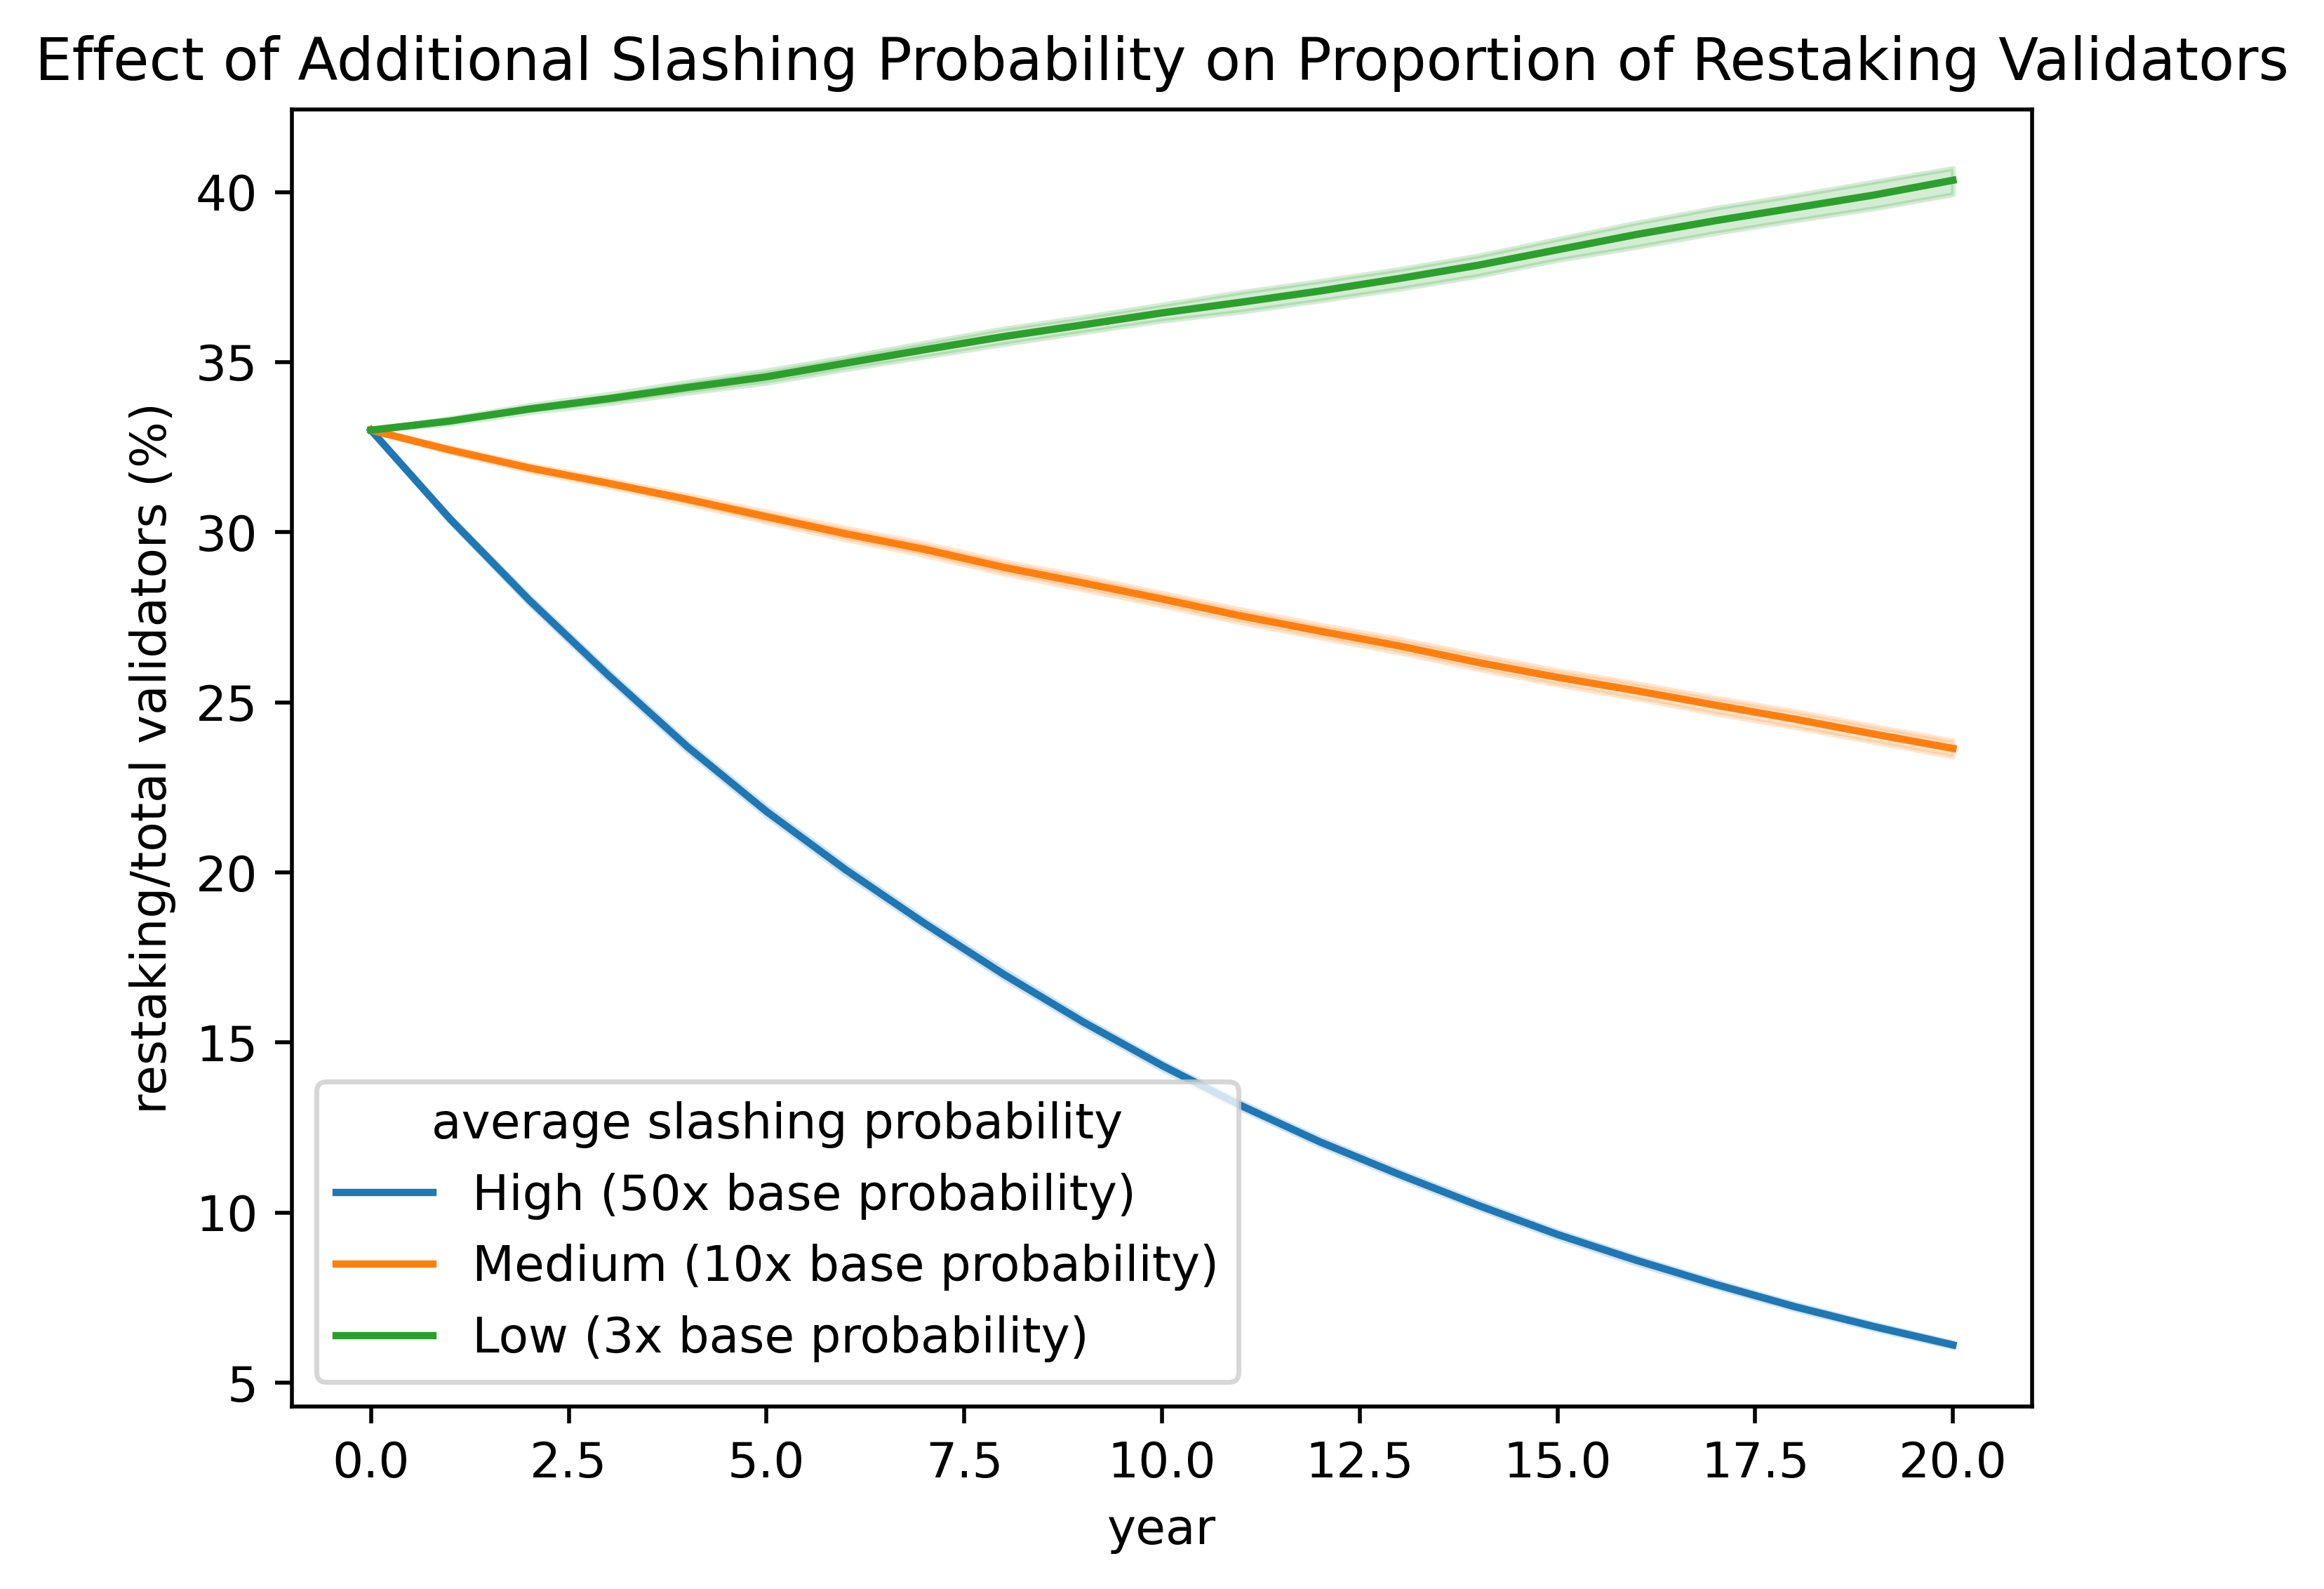

In [ ]:
g = sns.lineplot(data=df.assign(slashing_severity=df['scenario'].map(scenarios)), x="year", y="percent", hue='slashing_severity', hue_order= hue_order0).set(title='Effect of Additional Slashing Probability on Proportion of Restaking Validators')
plt.ylabel('restaking/total validators (%)')
plt.legend(title='average slashing probability')
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)